In [1]:
import sys
import math
sys.path.insert(0, "..")

import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functional, losses
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7f1beec90640>, 5)

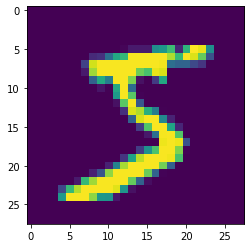

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

Let's built Conv2d in edunets:

In [3]:
# Simple pytorch example

# 3 (input_channels) 6 (out_channels) 3 (kernel_size)
m = nn.Conv2d(3, 6, 3)
# 1 (batch size) 2 (input_channels) 4 (height) 4 (width)
input = torch.randn(1, 3, 4, 4)
output = m(input)
# 1 (batch size) 6 (out_channels) 2 (height post kernel) 2 (width post kernel)
output.shape, output

(torch.Size([1, 6, 2, 2]), tensor([[[[ 0.7136,  0.7422],
           [ 0.3852,  0.5552]],
 
          [[-0.8869,  0.3701],
           [ 0.1656,  0.2368]],
 
          [[-1.0318,  0.2899],
           [ 0.2688, -0.5311]],
 
          [[ 1.5749,  0.5413],
           [ 0.1856,  0.1857]],
 
          [[ 0.0438,  0.2012],
           [ 0.1618,  0.0932]],
 
          [[-0.4902, -0.1547],
           [-0.8586, -1.1010]]]], grad_fn=<ThnnConv2DBackward>))

In [4]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        # Paramaters
        self.in_channels = in_channels if isinstance(in_channels, tuple) else (in_channels, )
        self.out_channels = out_channels if isinstance(out_channels, tuple) else (out_channels, )
        self.stride = stride
        self.padding = padding

        # Initiating Kernel
        self.real_kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        stdv = 1./np.sqrt(math.prod(self.real_kernel_size))
        self.kernel = Tensor.uniform(*self.real_kernel_size, low=-stdv, high=stdv, requires_grad=True)

        # Initiating Bias
        if bias is True:
            stdv = 1./np.sqrt(out_channels if isinstance(out_channels, int) else math.prod(out_channels))
            self.bias = Tensor.uniform(out_channels, low=-stdv, high=stdv, requires_grad=True)
        else:
            self.bias = None

    def __call__(self, x):
        batch, in_channels, width, height = x.shape

        # Reshaping kernel to match the depth
        self.kernel = self.kernel.expand((*self.real_kernel_size, *self.out_channels))

        # Adding the batches
        self.kernel = self.kernel.reshape((batch, *self.real_kernel_size))
        self.bias = self.bias.reshape((batch, self.out_channels))

        return self.bias + functional.conv(x, self.kernel, stride=self.stride, padding=self.padding)


In [5]:
# edunets equivalent of pytorch's simple example

# 2 (input_channels) 2 (out_channels) 3 (kernel_size)
m = Conv2d(3, 6, 3)
# 1 (batch size) 2 (input_channels) 4 (width) 4 (height)
input = Tensor.uniform(1, 3, 4, 4)
output = m(input)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,3)  and requested shape (3,3,6)